https://www.kaggle.com/code/berkhanguzeller/flood-prediction-r-2-0-999-rmse-0-0005

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from xgboost import XGBRegressor
import optuna

In [8]:
df = pd.read_csv("flood.csv")
df

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3,7,4,7,5,9,4,6,10,4,...,7,3,8,8,6,1,5,4,2,0.535
49996,3,10,3,8,3,3,4,4,3,11,...,8,6,3,6,4,4,2,4,5,0.510
49997,4,4,5,7,2,1,4,5,6,7,...,4,6,4,1,5,1,6,4,3,0.430
49998,4,5,4,4,6,3,10,2,6,11,...,6,3,4,7,6,2,4,0,11,0.515


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 12  CoastalVulnerabili

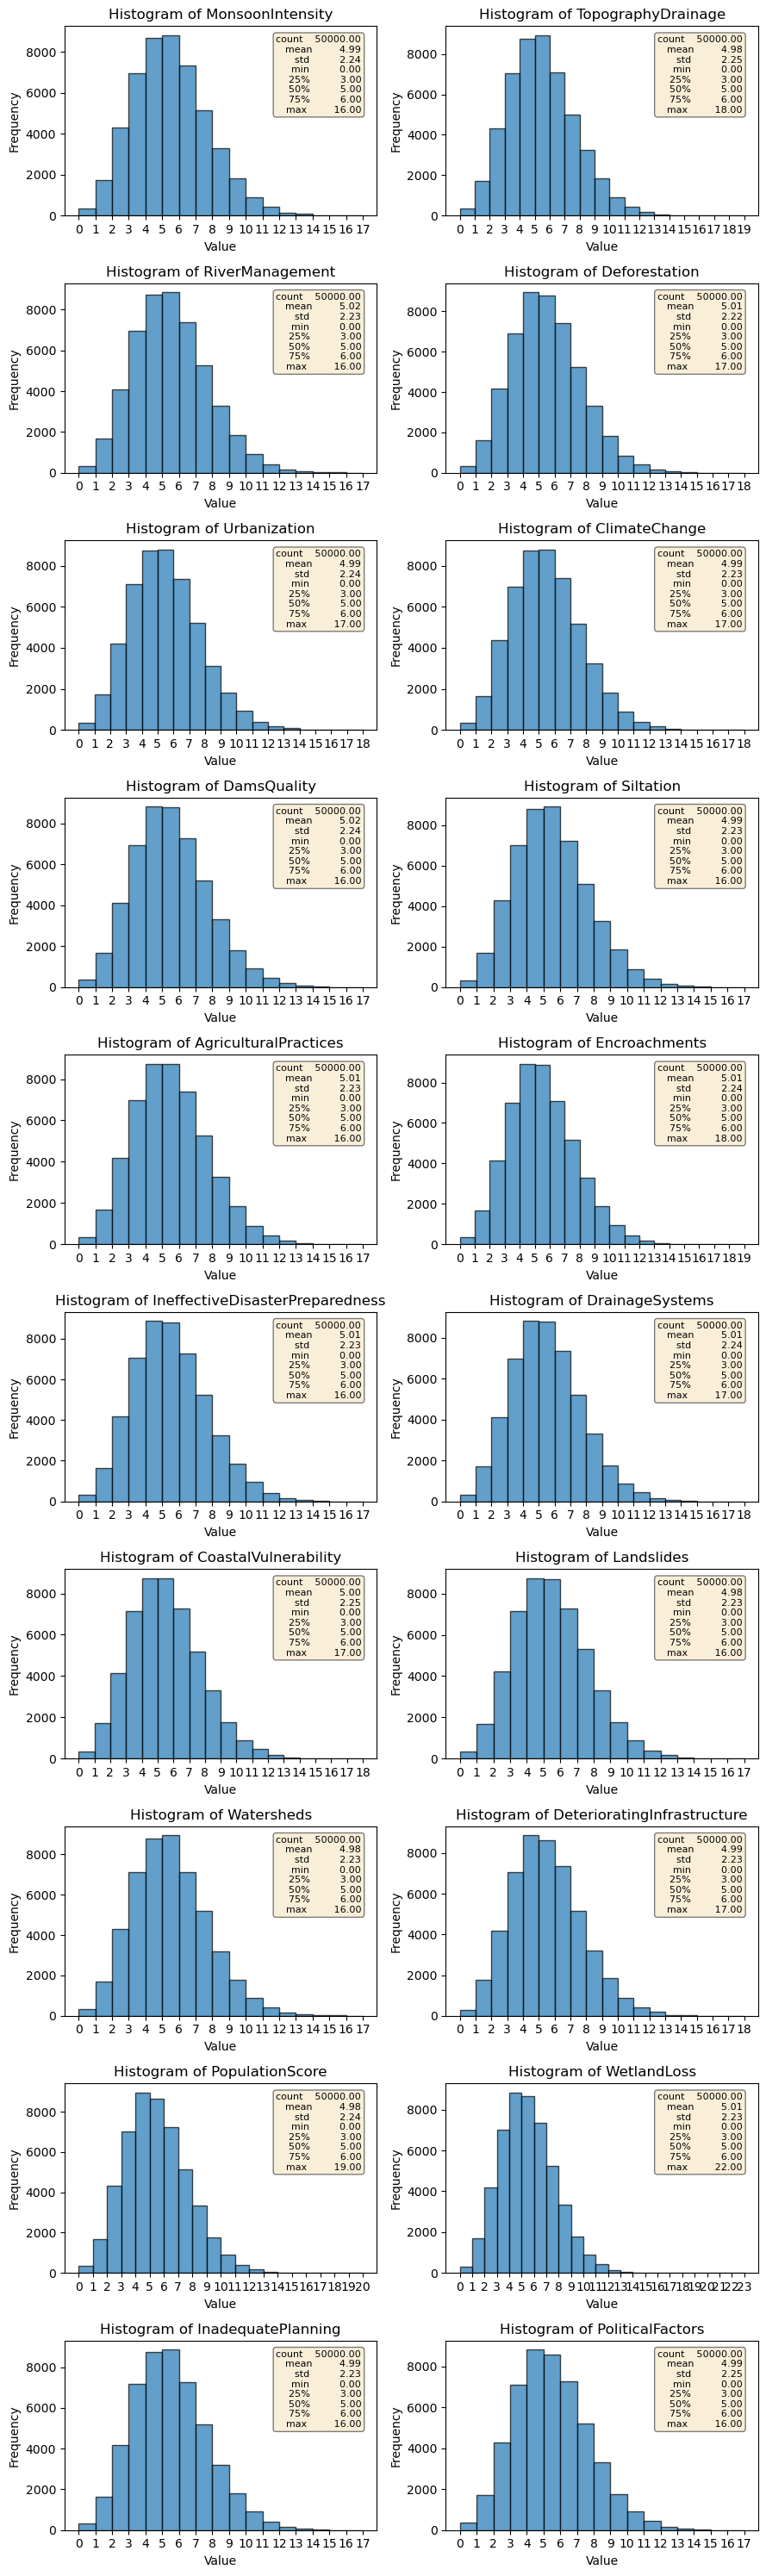

In [20]:
columns = df.drop("FloodProbability", axis = 1).columns
n_cols = 2
n_rows = int(np.ceil(len(columns) / n_cols))

# Create subplots
fig, axis = plt.subplots(nrows = n_rows, ncols = 2, figsize = (9, n_rows * 3))
axis = axis.flatten()

# Plot histograms for each column except "FloodProbability"
for i, column in enumerate(columns):
    ax = axis[i]
    col_data = df[column]
    bins = np.arange(col_data.min(), col_data.max() + 2)
    ax.hist(col_data, bins = bins, alpha = 0.7, edgecolor = "k")
    ax.set_title(f"Histogram of {column}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_xticks(bins)

    summary_text = col_data.describe().apply(lambda x: f"{x:.2f}").to_string()
    ax.text(0.95, 0.95, summary_text,  transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

for ax in axis[len(columns):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

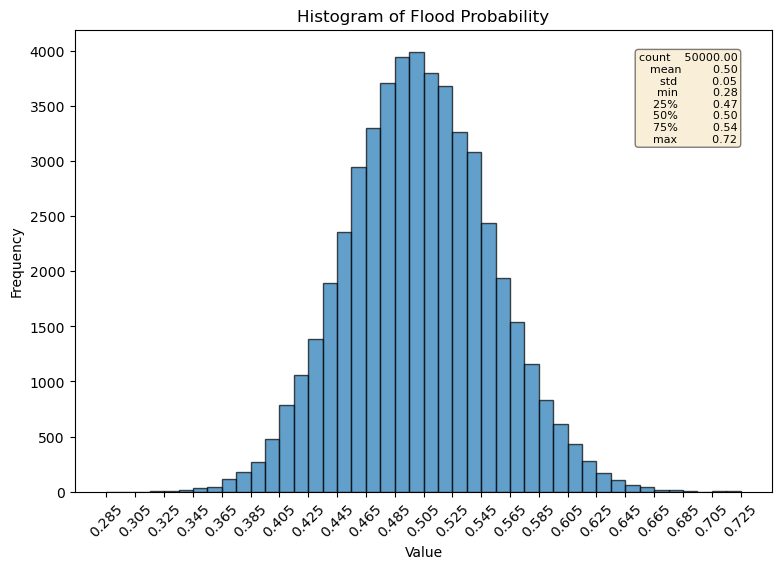

In [22]:
# Create subplots
fig, ax = plt.subplots(figsize = (9, 6))
bins = np.linspace(df["FloodProbability"].min(), df["FloodProbability"].max(), 45)

# Plot FloodProbability
ax.hist(df['FloodProbability'], bins=bins, alpha=0.7, edgecolor='k')
ax.set_title(f'Histogram of Flood Probability')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_xticks(bins[::2])
ax.tick_params(axis='x', rotation=45)
    
# Summary statistics text
summary_text = df['FloodProbability'].describe().apply(lambda x: f'{x:.2f}').to_string()
ax.text(0.95, 0.95, summary_text, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

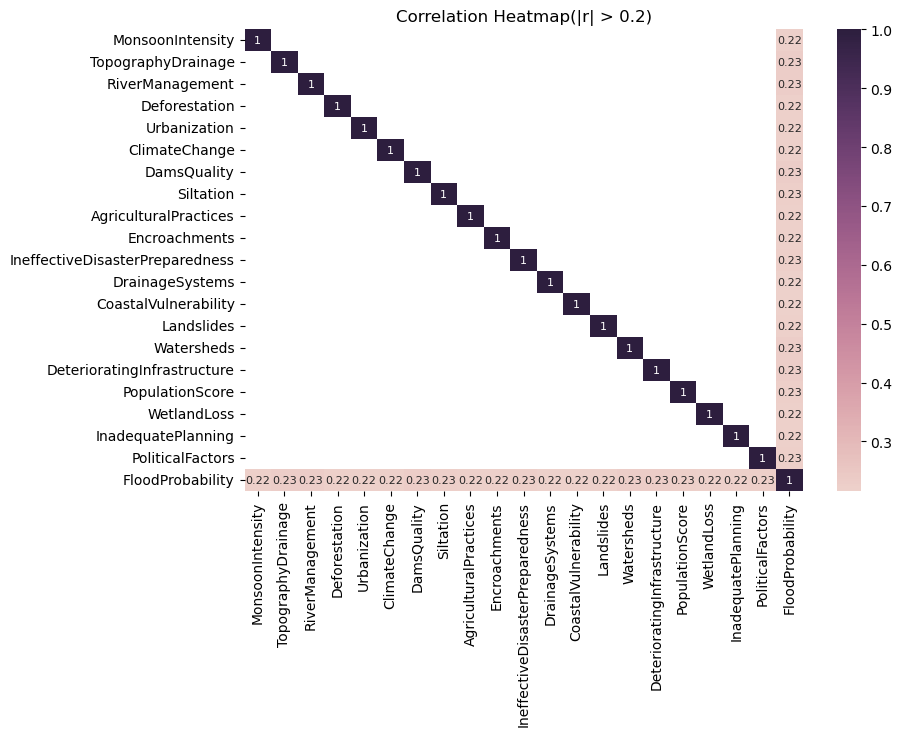

In [24]:
fig, ax = plt.subplots(figsize = (9, 6))

# Plot heatmap
corr_matrix = df.corr()
mask = np.abs(corr_matrix) > 0.2
sns.heatmap(corr_matrix, annot = True, cmap=sns.cubehelix_palette(as_cmap=True), mask=~mask, annot_kws={"size": 8})

plt.title("Correlation Heatmap(|r| > 0.2)")
plt.show()

In [34]:
def preprocess(df):
    df = df.copy()

    X = df.drop("FloodProbability", axis = 1)
    y = df["FloodProbability"]

    return X, y

In [36]:
X, y = preprocess(df)

In [40]:
def build_model(params = None):
    numerical_transformer = Pipeline(steps = [
        ("MinMaxScaler", MinMaxScaler())
    ]
        )

    preprocessor = ColumnTransformer(transformers = [
        ("Numerical Transformer", numerical_transformer, X.select_dtypes(np.number).columns)
    ])

    if params is None:
        xgbmodel = XGBRegressor(random_state = 42)
    else:
        xgbmodel = XGBRegressor(random_state = 42, **params)
        
    model = Pipeline(steps=[
        ('Preprocess', preprocessor),
        ('XGBModel', xgbmodel)
    ])
    
    return model

In [42]:
model = build_model()

cv_scores = cross_val_score(model, X, y, cv = 5, scoring = "neg_mean_squared_error")
cv_rmse = -cv_scores.mean()
print(f"Cross-validation RMSE: {cv_rmse}")

Cross-validation RMSE: 0.00017896880816605496


In [44]:
def print_metrics(target, predictions):
    rmse = np.sqrt(mean_squared_error(target, predictions))
    r2 = r2_score(target, predictions)
    mae = mean_absolute_error(target, predictions)
    print(f'Root Mean Squarred Error: {rmse}\nR-squared (r^2): {r2}\nMean Absolute Error: {mae}')

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('Numerical Transformer',
                                                  Pipeline(steps=[('MinMaxScaler',
                                                                   MinMaxScaler())]),
                                                  Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'D...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [48]:
predictions = model.predict(X_test)
print_metrics(y_test, predictions)

Root Mean Squarred Error: 0.013584748491394204
R-squared (r^2): 0.9261235596294177
Mean Absolute Error: 0.010802139900875092


In [54]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }
    
    model = build_model(params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [56]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-07-17 15:48:57,732] A new study created in memory with name: no-name-2037cb86-15d8-4ea8-aecd-5205adbfbda6
[I 2024-07-17 15:49:00,586] Trial 0 finished with value: 0.016442894071270902 and parameters: {'max_depth': 5, 'learning_rate': 0.005309105419810574, 'n_estimators': 1785, 'min_child_weight': 5, 'subsample': 0.6787821277262263, 'colsample_bytree': 0.6708743029855483, 'gamma': 0.00022878251732113964, 'reg_alpha': 0.029414138144173697, 'reg_lambda': 1.2073610707895093e-06}. Best is trial 0 with value: 0.016442894071270902.
[I 2024-07-17 15:49:01,507] Trial 1 finished with value: 0.035094311549365646 and parameters: {'max_depth': 2, 'learning_rate': 0.007755601226246756, 'n_estimators': 786, 'min_child_weight': 5, 'subsample': 0.7283746111866998, 'colsample_bytree': 0.5335573467138313, 'gamma': 5.750078274411303e-05, 'reg_alpha': 1.886556311380499e-08, 'reg_lambda': 5.819488960299744e-07}. Best is trial 0 with value: 0.016442894071270902.
[I 2024-07-17 15:49:03,992] Trial 2 fi

In [60]:
best_params = study.best_params
best_params

{'max_depth': 1,
 'learning_rate': 0.2707684979790731,
 'n_estimators': 1595,
 'min_child_weight': 5,
 'subsample': 0.9843452552016424,
 'colsample_bytree': 0.8492817465867413,
 'gamma': 3.9560105107178945e-08,
 'reg_alpha': 2.8349443726075448e-08,
 'reg_lambda': 0.06269703346038183}

In [62]:
model = build_model(best_params)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_metrics(y_test, predictions)

Root Mean Squarred Error: 0.0004595548653425169
R-squared (r^2): 0.9999154570313532
Mean Absolute Error: 0.00017388273954391508


def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }
    
    model = XGBRegressor(params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

First, tell me about optuna library. Then tell me in detail what the above code is doing. Also tell about "trial" which is used in above code.

### About Optuna Library

**Optuna** is an automatic hyperparameter optimization software framework designed specifically for machine learning models. It allows users to automate the search for the optimal hyperparameters, which can significantly enhance model performance. Optuna provides features such as:
- **Efficient optimization algorithms**: Including Tree-structured Parzen Estimator (TPE) and others.
- **Pruning**: Early stopping of unpromising trials to save time.
- **Parallelism**: Run multiple trials in parallel to speed up the optimization process.
- **Visualization**: Tools to visualize the optimization history and parameter importances.

### Explanation of the Code

The code provided uses Optuna to optimize the hyperparameters of an XGBoost regressor model. Here's a detailed breakdown:

1. **Define the Objective Function**:
    ```python
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 20),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        }
        
        model = XGBRegressor(**params)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        return rmse
    ```
    - **Objective Function**: This function defines the problem to be minimized, in this case, the Root Mean Squared Error (RMSE) of the model predictions.
    - **Parameters Dictionary (`params`)**: This dictionary contains hyperparameters for the `XGBRegressor`, each suggested by the `trial` object:
        - `max_depth`, `min_child_weight`, `n_estimators`: Integer hyperparameters.
        - `learning_rate`, `subsample`, `colsample_bytree`, `gamma`, `reg_alpha`, `reg_lambda`: Float hyperparameters.
    - **Model Training**: An XGBoost regressor is created with the suggested hyperparameters and trained on the training dataset.
    - **Prediction and Evaluation**: Predictions are made on the test dataset, and the RMSE is calculated and returned.

2. **Create and Optimize the Study**:
    ```python
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    ```
    - **Create Study**: Initializes an Optuna study object. The `direction='minimize'` specifies that the goal is to minimize the objective function (RMSE in this case).
    - **Optimize**: Runs the optimization process for 100 trials, where each trial corresponds to a single run of the objective function with a different set of hyperparameters.

### About `trial`

- **`trial` Object**: The `trial` object is provided by Optuna and is used to suggest hyperparameter values within specified ranges.
    - **`suggest_int(name, low, high)`**: Suggests an integer value within the specified range.
    - **`suggest_float(name, low, high, log=False)`**: Suggests a float value within the specified range. If `log=True`, the suggestion is in a logarithmic scale, useful for parameters like learning rate or regularization terms.
    
In summary, the code performs hyperparameter optimization for an XGBoost model using Optuna. The `trial` object is crucial in this process, as it helps in suggesting various hyperparameter values to find the optimal set that minimizes the RMSE.

study = optuna.create_study(direction='minimize')   
study.optimize(objective, n_trials=100)
   
   
Explain in detail

The code snippet:

```python
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
```

performs the following steps in detail:

### 1. Creating a Study

#### `optuna.create_study(direction='minimize')`

- **Purpose**: This line initializes a new Optuna study.
- **Study**: A study is an optimization task, which consists of multiple trials.
- **Direction**: The `direction='minimize'` argument specifies that the objective of the optimization is to minimize the value returned by the objective function. In this case, it aims to minimize the Root Mean Squared Error (RMSE).

#### Detailed Steps:
- **Initialization**: Optuna sets up an internal environment to manage trials and the optimization process.
- **Storage**: If no specific storage is provided, Optuna will store the study results in memory. You can also use a database (like SQLite) to persist the study results by providing a storage URL.
- **Sampler**: Optuna uses a sampler (default is TPE, Tree-structured Parzen Estimator) to suggest hyperparameters for each trial. This sampler tries to find the most promising hyperparameters based on past trials.

### 2. Optimizing the Study

#### `study.optimize(objective, n_trials=100)`

- **Purpose**: This line starts the optimization process, running the objective function `n_trials` times (100 times in this case).

#### Detailed Steps:

1. **Objective Function Execution**:
   - The `objective` function is called for each trial. It contains the logic for training the model and evaluating its performance.
   
2. **Hyperparameter Suggestion**:
   - For each trial, the `trial` object suggests hyperparameters using methods like `suggest_int`, `suggest_float`, etc. These suggestions are based on the previous trials and the TPE sampler's strategy to explore promising areas of the hyperparameter space.
   
3. **Model Training and Evaluation**:
   - The model is trained with the suggested hyperparameters.
   - Predictions are made on the test set.
   - The RMSE is calculated and returned as the trial's result.
   
4. **Trial Completion**:
   - The result (RMSE) is recorded, and the study updates its knowledge of the hyperparameter space.
   - The best trial (with the lowest RMSE) is tracked.

5. **Repetition**:
   - Steps 1 to 4 are repeated for `n_trials` (100 times).
   - The sampler continually updates its strategy based on the results of completed trials, aiming to improve the hyperparameter suggestions and find better solutions.

### Summary

By the end of the optimization process, the study contains:

- **Trial Results**: Records of all 100 trials, including the hyperparameters used and their corresponding RMSE.
- **Best Trial**: The trial with the lowest RMSE, which provides the optimal set of hyperparameters found during the optimization process.

The key advantage of using Optuna for hyperparameter tuning is its efficient search algorithms (like TPE) and the ability to prune unpromising trials early, saving computational resources and time.

Where is the "trial" object being created ?

The "trial" object in Optuna is created internally during the optimization process. Here is a detailed explanation of where and how it is created:

### Study Optimization Process

1. **Initialization**: When `study.optimize(objective, n_trials=100)` is called, Optuna prepares to execute the specified number of trials.

2. **Trial Creation**: For each trial, Optuna internally calls the objective function you provided, and it creates a `trial` object as part of this call.

### Detailed Process

- **Objective Function Call**: Optuna manages the execution of the `objective` function. Each time it calls this function, it passes a `trial` object to it.
  
  ```python
  def objective(trial):
      # trial is created and passed here by Optuna
      params = {
          'max_depth': trial.suggest_int('max_depth', 1, 20),
          'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
          'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
          'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
          'subsample': trial.suggest_float('subsample', 0.5, 1.0),
          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
          'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
          'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
          'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
      }
      
      model = XGBRegressor(params)
      model.fit(X_train, y_train)
      
      preds = model.predict(X_test)
      rmse = np.sqrt(mean_squared_error(y_test, preds))
      return rmse
  ```

### Internal Mechanics

- **Creating a Trial**: When Optuna decides to execute a new trial, it internally creates a `Trial` object. This object is responsible for managing hyperparameter suggestions and storing trial-specific data.
  
- **Passing the Trial Object**: Optuna passes the created `trial` object to your `objective` function. This happens seamlessly within the `study.optimize()` method.

### Example Breakdown

1. **Study Initialization**:
   ```python
   study = optuna.create_study(direction='minimize')
   ```

2. **Optimization Call**:
   ```python
   study.optimize(objective, n_trials=100)
   ```

3. **Internal Loop**:
   - For each trial (up to 100 times):
     - Optuna creates a new `Trial` object.
     - The `objective` function is called with this `Trial` object.
     - Inside the `objective` function, the `trial` object is used to suggest hyperparameters.
     - The model is trained and evaluated using these hyperparameters.
     - The result (RMSE) is recorded and the trial is completed.

### Summary

The `trial` object is not explicitly created by you in your code. Instead, it is created and managed internally by Optuna during the optimization process. Each time the `objective` function is called, Optuna passes a new `trial` object to it, which you then use to suggest hyperparameters and evaluate the model.

'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)
   
Now explain it in detail that how it will be selected 100 times and used for training the model

The line of code `trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)` is part of the hyperparameter optimization process within the Optuna framework. Here's a detailed explanation of how this works over 100 trials:

### What the Line Does
- **`trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)`**:
  - **Purpose**: Suggests a floating-point value for the hyperparameter `learning_rate`.
  - **Range**: The value is suggested between \(0.001\) (1e-3) and \(1.0\).
  - **Log Scale**: The `log=True` argument means that the values are sampled on a logarithmic scale, which is useful when the range spans several orders of magnitude. This means that values closer to the lower end (0.001) and upper end (1.0) are sampled more frequently.

### How It Works in 100 Trials
1. **Initialization**:
   - When you call `study.optimize(objective, n_trials=100)`, Optuna prepares to run the objective function 100 times.

2. **Each Trial**:
   - For each of the 100 trials, the following happens:
     - **Create Trial Object**: Optuna creates a new `trial` object.
     - **Suggest Hyperparameters**: The `trial.suggest_float` function is called within your objective function to suggest a value for `learning_rate`.
     - **Sampling**: 
       - Because `log=True`, Optuna samples values in the range [0.001, 1.0] on a logarithmic scale. 
       - This might result in sampled values like 0.001, 0.01, 0.1, and so on, with finer granularity as it explores the space.
     - **Training the Model**:
       - The suggested `learning_rate` (and other hyperparameters) are used to train the model.
       - For instance, if the suggested `learning_rate` for a particular trial is 0.01, the model will be trained using `learning_rate=0.01`.

3. **Evaluation**:
   - After training the model with the suggested `learning_rate`, the model's performance is evaluated using a metric like RMSE (Root Mean Squared Error).
   - The RMSE value is returned as the result of the trial.

4. **Repeat**:
   - This process is repeated for each of the 100 trials.
   - Each trial gets a different set of hyperparameters based on the suggestions from the `trial` object.

5. **Optimization**:
   - Optuna uses the results from each trial to guide the hyperparameter search.
   - It employs strategies like Tree-structured Parzen Estimator (TPE) to decide how to sample hyperparameters in subsequent trials, aiming to find the best-performing hyperparameters efficiently.

### Example Breakdown

Let's go through a hypothetical example of how the `learning_rate` might be selected and used in several trials:

- **Trial 1**:
  - Suggested `learning_rate`: 0.005 (sampled from the log-scaled range)
  - Train the model with `learning_rate=0.005`
  - Evaluate and record RMSE

- **Trial 2**:
  - Suggested `learning_rate`: 0.02
  - Train the model with `learning_rate=0.02`
  - Evaluate and record RMSE

- **Trial 3**:
  - Suggested `learning_rate`: 0.0015
  - Train the model with `learning_rate=0.0015`
  - Evaluate and record RMSE

- ...

- **Trial 100**:
  - Suggested `learning_rate`: 0.75
  - Train the model with `learning_rate=0.75`
  - Evaluate and record RMSE

### Summary

Optuna's `suggest_float` method samples the `learning_rate` hyperparameter on a log scale, suggesting values within the specified range for each trial. This helps in exploring a wide range of values efficiently. Over 100 trials, this process helps in identifying the `learning_rate` that yields the best model performance based on the chosen evaluation metric.

On each trial, will the value of "learning_rate" be picked up randomly ?

In Optuna, the value of `learning_rate` in each trial is not picked randomly but is selected based on a sampling strategy that aims to optimize the search process. Here's a detailed explanation:

### Initial Trials
In the early trials, Optuna uses a random sampling approach to explore the search space broadly. This allows it to gather information about how different values of `learning_rate` (and other hyperparameters) affect the model's performance.

### Subsequent Trials
After the initial exploration phase, Optuna employs a more informed search strategy, typically using the Tree-structured Parzen Estimator (TPE) sampler by default. This is a Bayesian optimization method that builds probabilistic models of the objective function to identify promising regions of the search space. 

#### Key Points:
1. **Probabilistic Modeling**: TPE builds two models: one for the distribution of hyperparameters that are likely to yield good results and one for the distribution of all observed results.
2. **Efficient Search**: Based on these models, Optuna decides which hyperparameters to try in subsequent trials, focusing on areas that are more likely to improve the objective metric (e.g., minimizing RMSE).
3. **Guided Sampling**: The selection of `learning_rate` in later trials is guided by the performance of previous trials, rather than being purely random. This helps in converging towards better-performing hyperparameter values more efficiently.

### Example Process
1. **Trial 1 to 10**: Randomly sample `learning_rate` values to gather initial performance data.
2. **Trial 11 to 100**: Use the TPE sampler to suggest `learning_rate` values based on the probabilistic model built from earlier trials. 

### Practical Implication
This approach balances exploration and exploitation:
- **Exploration**: Initially explores a wide range of values.
- **Exploitation**: Later focuses on promising regions identified from earlier trials.

### Summary
While the `learning_rate` might seem randomly picked in the early stages, as trials progress, the selection becomes more strategic and informed by the results of previous trials. This informed search strategy helps in finding optimal hyperparameters more efficiently than random search alone.

For more details on Optuna and its sampling strategies, you can refer to the [Optuna documentation](https://optuna.readthedocs.io/en/stable/index.html).

Let's say if total hyper-parmeters combination is 200 and we run the objective function 100 times, it means that we have not tried all the combinations. On the other hand, if we use GridSearchCV then it will check all the combinations. My question is, the use of optuna isn't just like RandomizedSearchCV which just picks hyperparameters randomly ?

You are correct that GridSearchCV exhaustively checks all possible combinations of hyperparameters within the specified ranges, ensuring that the optimal combination is found, albeit at the cost of potentially high computational expense. RandomizedSearchCV, on the other hand, samples a fixed number of hyperparameter combinations from the specified ranges, which makes it faster but potentially less exhaustive.

Optuna, while it might initially seem similar to RandomizedSearchCV due to its exploratory sampling, actually employs a more sophisticated strategy. Here are the key differences and advantages of Optuna compared to both GridSearchCV and RandomizedSearchCV:

### Optuna vs. GridSearchCV
- **Efficiency**: GridSearchCV can be computationally expensive, especially with a large hyperparameter space. Optuna is more efficient because it does not need to evaluate all combinations.
- **Scalability**: Optuna can handle larger search spaces more effectively by focusing the search on promising areas, reducing the number of trials needed to find good hyperparameters.
- **Flexibility**: Optuna can use various samplers (e.g., TPE) and pruners to optimize the search process dynamically, which GridSearchCV lacks.

### Optuna vs. RandomizedSearchCV
- **Informed Search**: RandomizedSearchCV samples hyperparameters randomly throughout the search space. Optuna starts with random sampling but then uses the results from previous trials to inform future sampling, making it more likely to find optimal hyperparameters efficiently.
- **Bayesian Optimization**: Optuna often uses Bayesian optimization (TPE sampler) to model the objective function and select hyperparameters based on this model, rather than purely random sampling.

### Summary
- **Optuna** uses an intelligent, guided search process that balances exploration (sampling broadly) and exploitation (focusing on promising areas). It starts with random sampling but quickly learns from results to make informed decisions, improving efficiency and effectiveness compared to RandomizedSearchCV.
- **GridSearchCV** is exhaustive but computationally expensive.
- **RandomizedSearchCV** is faster but less exhaustive and informed compared to Optuna.

In essence, Optuna provides a more advanced and efficient method for hyperparameter optimization, combining the benefits of both RandomizedSearchCV's speed and GridSearchCV's thoroughness, while adding intelligence to the search process.

### Practical Example
If you run Optuna's `objective` function 100 times on a search space with 200 possible combinations, Optuna will likely find a near-optimal combination without evaluating all 200 combinations, thanks to its informed search strategy. In contrast, GridSearchCV would need to evaluate all 200 combinations to ensure the optimal one is found, and RandomizedSearchCV would randomly sample 100 combinations without any informed guidance from previous results.

For more detailed insights, you can refer to the [Optuna documentation](https://optuna.readthedocs.io/en/stable/index.html) and explore its advanced features like pruning and different samplers.

In [77]:
import joblib

In [79]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [81]:
loaded_model = joblib.load("model.joblib")

In [83]:
loaded_model.predict(X_test.to_numpy())

ValueError: Specifying the columns using strings is only supported for dataframes.

In [105]:
import pickle
with open("model1.pk2", "wb") as file:
    pickle.dump(model, file)

In [111]:
with open("model1.pk2", "rb") as file:
    load = pickle.load(file)

In [113]:
load.predict(X_test)

array([0.4547725 , 0.49493784, 0.4698244 , ..., 0.54991126, 0.47972003,
       0.5352465 ], dtype=float32)